In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time

from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model

In [2]:
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor(726.5942, shape=(), dtype=float32)


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
devices = tf.config.list_physical_devices("GPU")
devices 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
#tf.config.experimental.set_memory_growth(devices[0], enable=True)

In [7]:
BATCH_SIZE = 1
IMAGE_SIZE = 256

In [8]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    w = tf.shape(image)[1]
    w = w//2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

In [9]:
path = "C:\\Users\\Abhishake Sing\\Desktop\\Workplace\\GAN\\pix2pix\\archive\\facades\\facades\\"
x,y = load(os.path.join(path, "train/10.jpg"))
print(x.shape, y.shape)

(256, 256, 3) (256, 256, 3)


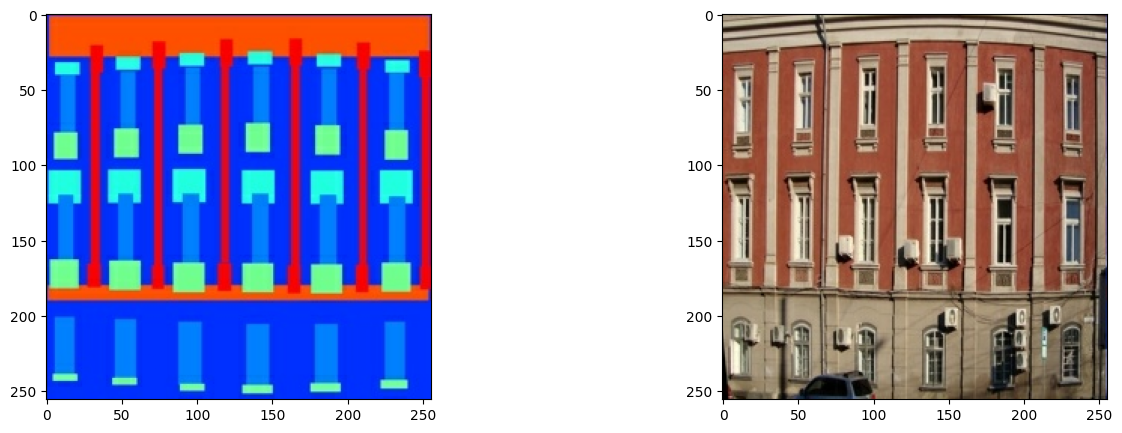

In [10]:
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(x/255.0)
axes[1].imshow(y/255.0)

In [11]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

In [12]:
def resize(input_image, real_image):
    input_image = tf.image.resize(input_image, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [13]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis = 0)
    cropped_image = tf.image.random_crop(stacked_image, size = [2, IMAGE_SIZE, IMAGE_SIZE, 3])
    return cropped_image[0], cropped_image[1]

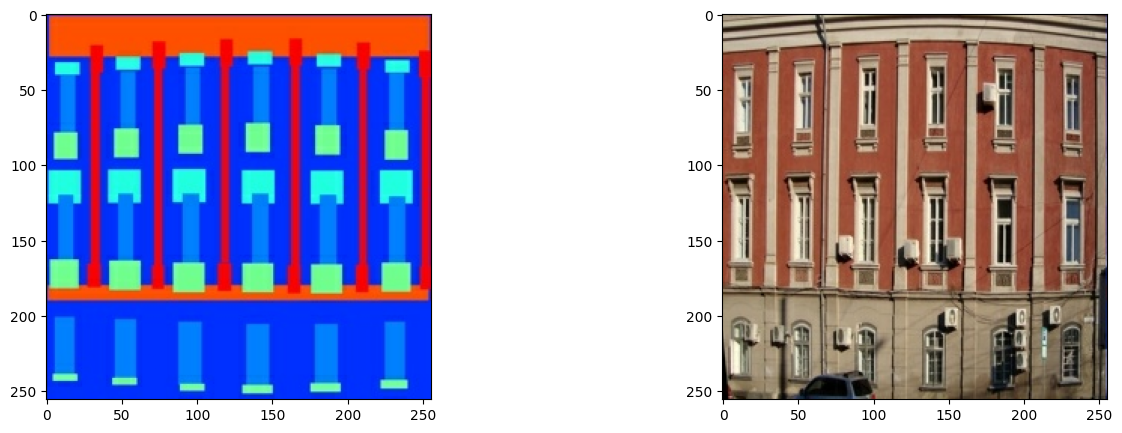

In [14]:
x_aug, y_aug = random_crop(x, y)
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(x_aug/255.0)
axes[1].imshow(y_aug/255.0)

In [15]:
def random_jitter(input_image, real_image):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

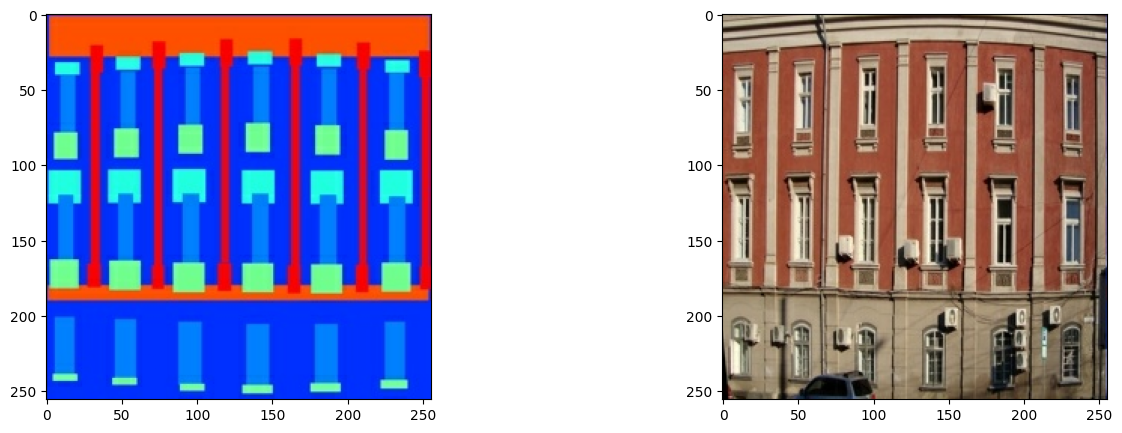

In [16]:
x_jit, y_jit = random_jitter(x, y)
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(x_jit/255.0)
axes[1].imshow(y_jit/255.0)

In [17]:
def load_train_images(image_path):
    input_image, real_image = load(image_path)
    input_image, real_image = resize(input_image, real_image)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image,real_image

In [18]:
def load_test_image(image_path):
    input_image, real_image = load(image_path)
    input_image, real_image = resize(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [19]:
train_dataset = tf.data.Dataset.list_files(path + "train/*.jpg")
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [20]:
test_dataset = tf.data.Dataset.list_files(path + "val/*.jpg")
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [21]:
def downsample(filters, size, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())
        
    result.add(LeakyReLU())
    return result
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(x, axis = 0))
print(down_result.shape)

(1, 128, 128, 3)


In [22]:
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [23]:
def generator():
    inputs = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3])
    down_stack = [
        downsample(64, 4, batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]
    
    
    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(512, 4, dropout=True),
        upsample(512, 4),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    
    x = last(x)
    return Model(inputs = inputs, outputs = x)

In [24]:
gen = generator()
gen.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_3 (Sequential)      (None, 64, 64, 128)  131584      ['sequential_2[0][0]']           
                                                                                              

In [25]:
#plot_model(gen, show_shapes=True, dpi = 64)

In [26]:
LAMBDA = 100

In [27]:
from keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [29]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    
    inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3], name = "input_image")
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3], name = "target_image")
    x = Concatenate()([inp, tar])
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

In [30]:
disc = discriminator()
disc.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

In [31]:
#plot_model(disc, show_shapes=True, dpi = 64)

In [32]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [33]:
generator_optimizer = Adam(lr= 2e-4, beta_1=0.5)
discriminator_optimizer = Adam(lr = 2e-4, beta_1=0.5)

C:\Users\Abhishake Sing\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [34]:
def save_images(model, test_input, target, epoch):
    prediction = model(test_input, training= True)
    plt.figure(figsize = (15,15))
    display_list= [test_input[0], target[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicton Image"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.savefig(f"output/epoch_{epoch}.jpg")
    plt.close()

In [35]:
#if os.path.exists("C:\\Users\\Abhishake Sing\\Desktop\\Workplace\\GAN\\pix2pix\\archive\\facades\\facades"):
#    os.mkdir("output")

In [36]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training = True)
        
        disc_real_output = disc([input_image, target], training = True)
        disc_generated_output = disc([input_image, gen_output], training = True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
        return gen_total_loss, disc_loss

In [37]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        for input_, target in test_ds.take(1):
            save_images(gen, input_, target, epoch)
        # Train
        print(f"Epoch {epoch}")
        for n, (input_, target) in train_ds.enumerate():
            gen_loss, disc_loss = train_step(input_, target, epoch)
        print("Generator loss {:.2f} Discriminator loss {:.2f}".format(gen_loss, disc_loss))
        print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))
        

In [38]:
import keras
keras.backend.clear_session()

In [39]:
epochs = 500

In [40]:
fit(train_dataset, epochs, test_dataset)

Epoch 0
Generator loss 33.81 Discriminator loss 0.24
Time take for epoch 1 is 84.44253826141357 sec

Epoch 1
Generator loss 36.18 Discriminator loss 0.71
Time take for epoch 2 is 71.72325038909912 sec

Epoch 2
Generator loss 31.14 Discriminator loss 0.81
Time take for epoch 3 is 58.92176699638367 sec

Epoch 3
Generator loss 42.88 Discriminator loss 0.21
Time take for epoch 4 is 58.79806113243103 sec

Epoch 4
Generator loss 35.54 Discriminator loss 0.59
Time take for epoch 5 is 59.28402042388916 sec

Epoch 5
Generator loss 34.58 Discriminator loss 0.74
Time take for epoch 6 is 59.61999988555908 sec

Epoch 6
Generator loss 30.28 Discriminator loss 1.58
Time take for epoch 7 is 59.48257255554199 sec

Epoch 7
Generator loss 40.25 Discriminator loss 0.43
Time take for epoch 8 is 59.568233489990234 sec

Epoch 8
Generator loss 45.58 Discriminator loss 0.48
Time take for epoch 9 is 59.27330732345581 sec

Epoch 9
Generator loss 37.88 Discriminator loss 0.66
Time take for epoch 10 is 59.73700523

Epoch 80
Generator loss 16.40 Discriminator loss 0.79
Time take for epoch 81 is 59.438979625701904 sec

Epoch 81
Generator loss 11.23 Discriminator loss 0.54
Time take for epoch 82 is 59.574169635772705 sec

Epoch 82
Generator loss 14.48 Discriminator loss 0.62
Time take for epoch 83 is 59.65396022796631 sec

Epoch 83
Generator loss 12.42 Discriminator loss 0.96
Time take for epoch 84 is 59.58872365951538 sec

Epoch 84
Generator loss 19.39 Discriminator loss 0.81
Time take for epoch 85 is 59.513731241226196 sec

Epoch 85
Generator loss 14.75 Discriminator loss 0.53
Time take for epoch 86 is 59.5199761390686 sec

Epoch 86
Generator loss 11.83 Discriminator loss 0.99
Time take for epoch 87 is 59.59299993515015 sec

Epoch 87
Generator loss 17.91 Discriminator loss 0.49
Time take for epoch 88 is 59.472464084625244 sec

Epoch 88
Generator loss 16.93 Discriminator loss 1.04
Time take for epoch 89 is 59.569918155670166 sec

Epoch 89
Generator loss 15.85 Discriminator loss 1.42
Time take for e

Epoch 159
Generator loss 13.57 Discriminator loss 1.52
Time take for epoch 160 is 59.50556206703186 sec

Epoch 160
Generator loss 15.59 Discriminator loss 0.71
Time take for epoch 161 is 59.41855525970459 sec

Epoch 161
Generator loss 11.34 Discriminator loss 1.37
Time take for epoch 162 is 59.50372815132141 sec

Epoch 162
Generator loss 11.13 Discriminator loss 0.80
Time take for epoch 163 is 59.46025800704956 sec

Epoch 163
Generator loss 10.31 Discriminator loss 1.18
Time take for epoch 164 is 59.57376027107239 sec

Epoch 164
Generator loss 15.16 Discriminator loss 0.68
Time take for epoch 165 is 59.70063233375549 sec

Epoch 165
Generator loss 13.50 Discriminator loss 0.80
Time take for epoch 166 is 59.5230028629303 sec

Epoch 166
Generator loss 9.96 Discriminator loss 0.91
Time take for epoch 167 is 59.54201793670654 sec

Epoch 167
Generator loss 11.31 Discriminator loss 0.47
Time take for epoch 168 is 59.5682487487793 sec

Epoch 168
Generator loss 10.67 Discriminator loss 0.86
Tim

Epoch 238
Generator loss 9.51 Discriminator loss 1.34
Time take for epoch 239 is 59.900359869003296 sec

Epoch 239
Generator loss 8.41 Discriminator loss 1.30
Time take for epoch 240 is 59.66619920730591 sec

Epoch 240
Generator loss 12.31 Discriminator loss 0.87
Time take for epoch 241 is 59.75701093673706 sec

Epoch 241
Generator loss 9.96 Discriminator loss 0.78
Time take for epoch 242 is 59.827701807022095 sec

Epoch 242
Generator loss 10.20 Discriminator loss 1.00
Time take for epoch 243 is 59.82104539871216 sec

Epoch 243
Generator loss 7.70 Discriminator loss 0.90
Time take for epoch 244 is 59.71123671531677 sec

Epoch 244
Generator loss 9.71 Discriminator loss 1.25
Time take for epoch 245 is 59.636451959609985 sec

Epoch 245
Generator loss 12.96 Discriminator loss 1.03
Time take for epoch 246 is 59.78621864318848 sec

Epoch 246
Generator loss 10.50 Discriminator loss 0.97
Time take for epoch 247 is 59.87523412704468 sec

Epoch 247
Generator loss 8.05 Discriminator loss 1.00
Tim

Epoch 317
Generator loss 6.00 Discriminator loss 1.13
Time take for epoch 318 is 59.72099184989929 sec

Epoch 318
Generator loss 11.48 Discriminator loss 1.01
Time take for epoch 319 is 60.0110080242157 sec

Epoch 319
Generator loss 9.09 Discriminator loss 0.86
Time take for epoch 320 is 59.776999950408936 sec

Epoch 320
Generator loss 10.46 Discriminator loss 0.83
Time take for epoch 321 is 59.740999937057495 sec

Epoch 321
Generator loss 6.70 Discriminator loss 1.18
Time take for epoch 322 is 59.66799998283386 sec

Epoch 322
Generator loss 7.93 Discriminator loss 1.06
Time take for epoch 323 is 59.938000202178955 sec

Epoch 323
Generator loss 9.28 Discriminator loss 1.24
Time take for epoch 324 is 59.67699956893921 sec

Epoch 324
Generator loss 10.94 Discriminator loss 0.70
Time take for epoch 325 is 59.81100034713745 sec

Epoch 325
Generator loss 8.54 Discriminator loss 1.27
Time take for epoch 326 is 59.84399151802063 sec

Epoch 326
Generator loss 6.70 Discriminator loss 1.18
Time 

Epoch 396
Generator loss 10.29 Discriminator loss 0.62
Time take for epoch 397 is 59.766930103302 sec

Epoch 397
Generator loss 11.94 Discriminator loss 0.42
Time take for epoch 398 is 59.82052040100098 sec

Epoch 398
Generator loss 10.45 Discriminator loss 0.36
Time take for epoch 399 is 59.864758253097534 sec

Epoch 399
Generator loss 10.80 Discriminator loss 0.28
Time take for epoch 400 is 59.59868597984314 sec

Epoch 400
Generator loss 9.21 Discriminator loss 0.86
Time take for epoch 401 is 59.61510968208313 sec

Epoch 401
Generator loss 9.59 Discriminator loss 0.52
Time take for epoch 402 is 59.75600004196167 sec

Epoch 402
Generator loss 13.02 Discriminator loss 0.56
Time take for epoch 403 is 59.94199013710022 sec

Epoch 403
Generator loss 5.84 Discriminator loss 1.88
Time take for epoch 404 is 59.78559756278992 sec

Epoch 404
Generator loss 10.66 Discriminator loss 0.62
Time take for epoch 405 is 59.668628454208374 sec

Epoch 405
Generator loss 14.01 Discriminator loss 0.24
Tim

Generator loss 9.60 Discriminator loss 0.48
Time take for epoch 475 is 59.875513792037964 sec

Epoch 475
Generator loss 11.64 Discriminator loss 0.17
Time take for epoch 476 is 59.84849309921265 sec

Epoch 476
Generator loss 17.29 Discriminator loss 0.23
Time take for epoch 477 is 59.90265941619873 sec

Epoch 477
Generator loss 12.86 Discriminator loss 0.24
Time take for epoch 478 is 59.41755414009094 sec

Epoch 478
Generator loss 14.28 Discriminator loss 0.60
Time take for epoch 479 is 59.96407341957092 sec

Epoch 479
Generator loss 13.40 Discriminator loss 0.75
Time take for epoch 480 is 59.82379126548767 sec

Epoch 480
Generator loss 16.18 Discriminator loss 0.32
Time take for epoch 481 is 59.90966868400574 sec

Epoch 481
Generator loss 15.30 Discriminator loss 0.10
Time take for epoch 482 is 63.63600516319275 sec

Epoch 482
Generator loss 11.91 Discriminator loss 0.55
Time take for epoch 483 is 59.62650966644287 sec

Epoch 483
Generator loss 12.37 Discriminator loss 0.22
Time take 